In [43]:
#!pip install python-docx
#!pip install contextily

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 125 kB 4.7 MB/s eta 0:00:01
     |████████████████████████████████| 81 kB 5.2 MB/s  eta 0:00:01
     |████████████████████████████████| 21.5 MB 47.6 MB/s eta 0:00:01
     |████████████████████████████████| 40 kB 54.9 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [55]:
import os
import sys
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
from docx import Document
import matplotlib.pyplot as plt
from shapely import wkt
import geopandas as gpd
import contextily as ctx

from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.patches import Patch

from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

PROJECT_SRC_PATH = os.path.join( '/workspace/workspace/ufo-prediction', 'src-RCA')
sys.path.append(PROJECT_SRC_PATH)

import visualizations
import dataset

# Summary statistics

In [47]:
path_data_RCA = os.path.join(dataset.DATA_DIR, 'rca-ufo-CNN.csv')
df = pd.read_csv(path_data_RCA, encoding='latin1')
df['Zip_cd'] = df['Zip_cd'].astype(str)
df['NumberFloors_nb'] = pd.to_numeric(df['NumberFloors_nb'], errors='coerce')
df

,Unnamed: 0,PropertyKey_ID,Deal_id,Property_id,Status_tx,Status_dt,TransType_tx,country,Main Type,SubType,...,BldLenProxy,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Predicted Class,_merge
0,503,258966,499814,464167,closed,15/03/2008,Entity Level,Netherlands,Apartment,Garden,...,8.480678,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1,511,259004,488808,451626,closed,22/01/2008,Sale,Netherlands,Dev Site,Dev Site,...,33.402783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2,512,259005,500721,465261,closed,15/03/2008,Sale,Netherlands,Dev Site,Dev Site,...,33.402783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3,513,259006,502381,467404,closed,09/02/2007,Sale,Netherlands,Office,Office - Sub,...,33.402783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4,514,259007,2309350,1997038,closed,28/03/2019,Sale,Netherlands,Office,Office - Sub,...,46.501498,0.225379,0.143153,0.081831,0.104223,0.180017,0.095836,0.169561,0.0,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6136,83889,2385505,3729803,3717637,closed,29/03/2023,Sale,Spain,Industrial,Warehouse,...,56.329767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
6137,83905,2386951,3732279,3720303,closed,30/03/2023,Sale,Spain,Office,Office - Sub,...,50.229888,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
6138,83908,2387013,3732377,3720401,closed,31/03/2023,Sale,Spain,Seniors Housing & Care,Seniors Housing,...,34.945676,0.224388,0.125826,0.112308,0.131752,0.154641,0.132850,0.118236,0.0,both
6139,84167,2403285,3758153,3747999,closed,20/04/2023,Sale,Spain,Hotel,Limited Service,...,24.292422,0.292903,0.168690,0.100329,0.103362,0.138473,0.096957,0.099285,0.0,both


In [48]:
# Separate numeric and non-numeric (categorical) columns
numeric_cols = df.select_dtypes(include=[np.number])  # Selects all numeric columns
categorical_cols = df.select_dtypes(exclude=[np.number])  # Selects all non-numeric columns

# Summary for numeric columns: default stats including mean, std, etc.
numeric_summary = numeric_cols.describe().round(3).transpose()
numeric_summary.reset_index(inplace=True)
numeric_summary.rename(columns={'index': 'Statistic'}, inplace=True)
numeric_summary.insert(0, 'Data Source', 'Numeric Data')  # Change as necessary
numeric_summary.insert(2, 'Variable Description', 'Numerical Summary')

# Summary for categorical columns: count, unique, top, freq
categorical_summary = categorical_cols.describe(include='all').transpose()
categorical_summary.reset_index(inplace=True)
categorical_summary.rename(columns={'index': 'Statistic'}, inplace=True)
categorical_summary.insert(0, 'Data Source', 'Categorical Data')  # Change as necessary
categorical_summary.insert(2, 'Variable Description', 'Categorical Summary')


In [19]:
from docx import Document

def df_to_word(numeric_df, categorical_df, filename):
    doc = Document()
    
    # Adding Numeric Summary Table
    doc.add_heading('Numeric Summary Statistics', level=1)
    num_table = doc.add_table(rows=(numeric_df.shape[0] + 1), cols=numeric_df.shape[1])
    for i, col_name in enumerate(numeric_df.columns):
        num_table.cell(0, i).text = str(col_name)
    for row_index, row in numeric_df.iterrows():
        for col_index in range(numeric_df.shape[1]):
            num_table.cell(row_index + 1, col_index).text = str(row[col_index])
    num_table.style = 'Table Grid'
    
    # Adding Categorical Summary Table
    doc.add_heading('Categorical Summary Statistics', level=1)
    cat_table = doc.add_table(rows=(categorical_df.shape[0] + 1), cols=categorical_df.shape[1])
    for i, col_name in enumerate(categorical_df.columns):
        cat_table.cell(0, i).text = str(col_name)
    for row_index, row in categorical_df.iterrows():
        for col_index in range(categorical_df.shape[1]):
            cat_table.cell(row_index + 1, col_index).text = str(row[col_index])
    cat_table.style = 'Table Grid'

    # Save the document
    doc.save(filename)

# Example usage
df_to_word(numeric_summary, categorical_summary, '/workspace/workspace/ufo-prediction/main notebooks/summary_statistics.docx')



# Building Age distribution

In [49]:
path_data_RCA = os.path.join(dataset.DATA_DIR, 'ufo-CNN_ALL.csv')
df_scaled = pd.read_csv(path_data_RCA, encoding='latin1')

<ipython-input-50-e20715197055>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['age_right_bracket'] = pd.cut(df['age_right'], bins=age_bins, labels=age_labels, right=False)


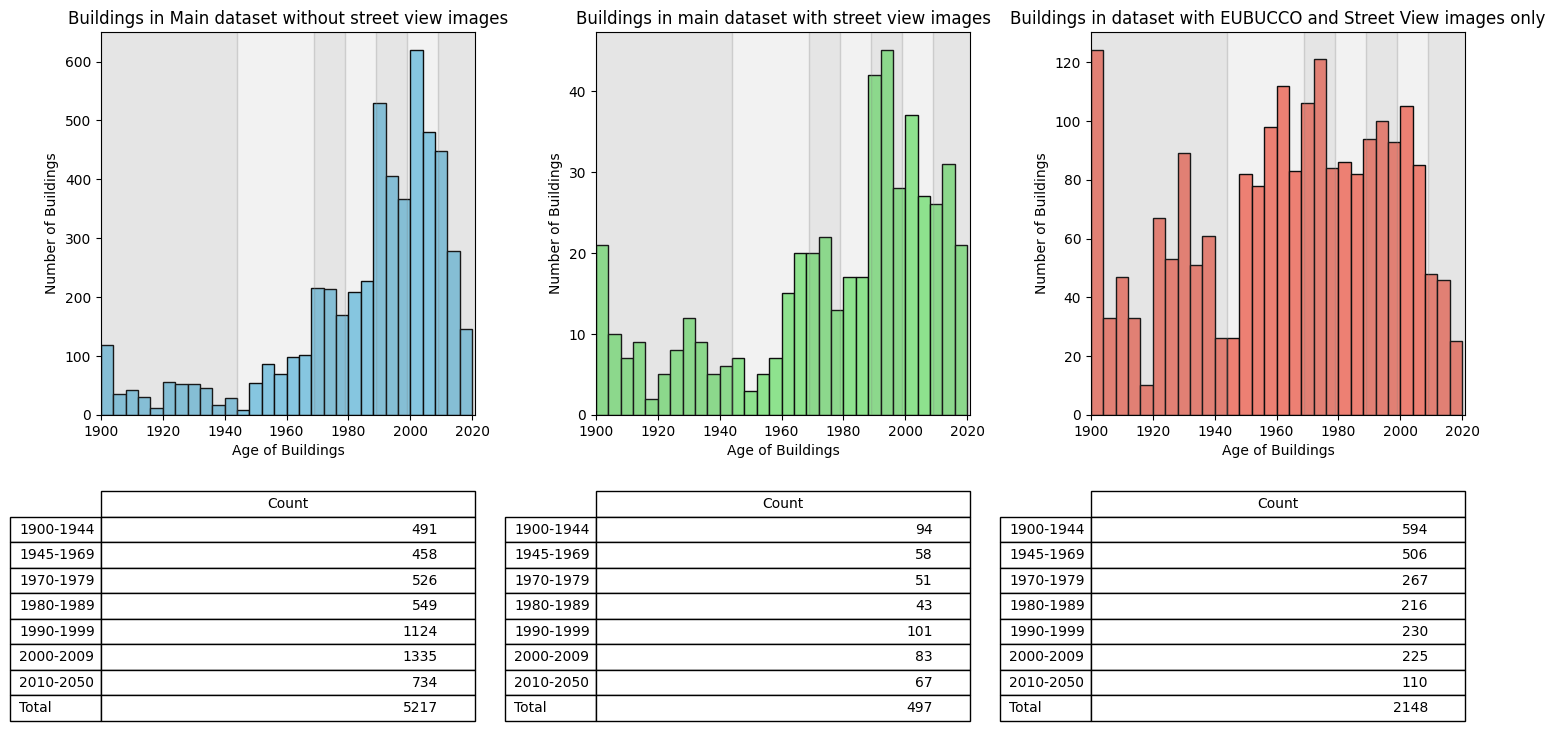

In [50]:
# Filtering to keep only buildings from 1900 onwards
df = df[df['age_right'] >= 1900]
df_scaled = df_scaled[df_scaled['age'] >= 1900]


# Define the age brackets
age_bins = [1900, 1944, 1969, 1979, 1989, 1999, 2009, 2050]
age_bins2 = [1900, 1944, 1969, 1979, 1989, 1999, 2009, 2021]
age_labels = ['1900-1944', '1945-1969', '1970-1979', '1980-1989', '1990-1999', '2000-2009', '2010-2050']

# Categorizing the 'age_right' and 'age' columns into age brackets
df['age_right_bracket'] = pd.cut(df['age_right'], bins=age_bins, labels=age_labels, right=False)
df_scaled['age_bracket'] = pd.cut(df_scaled['age'], bins=age_bins, labels=age_labels, right=False)

# Filtering data based on '_merge' values
df_only_left = df[df['_merge'] == 'left_only']
df_both = df[df['_merge'] == 'both']

# Histogram plotting
fig, axs = plt.subplots(1, 3, figsize=(15, 7), gridspec_kw={'width_ratios': [1, 1, 1]})
colors = ['skyblue', 'lightgreen', 'salmon']
data_sets = [df_only_left['age_right'], df_both['age_right'], df_scaled['age']]

for ax, data, color in zip(axs, data_sets, colors):
    ax.hist(data, color=color, edgecolor='black', bins=30)  # Specifying 30 bins for better granularity
    ax.set_xlim([1900, 2021])  # Set x-axis limits
    for i in range(len(age_bins)-1):
        ax.axvspan(age_bins[i], age_bins[i+1], color='gray', alpha=0.2 if i % 2 == 0 else 0.1)

# Adding titles and labels
titles = [
    'Buildings in Main dataset without street view images',
    'Buildings in main dataset with street view images',
    'Buildings in dataset with EUBUCCO and Street View images only'
]
for ax, title in zip(axs, titles):
    ax.set_title(title)
    ax.set_xlabel('Age of Buildings')
    ax.set_ylabel('Number of Buildings')

# Creating the tables below the histograms
for ax, data, column in zip(axs, [df_only_left, df_both, df_scaled], ['age_right_bracket', 'age_right_bracket', 'age_bracket']):
    count_data = data[column].value_counts().reindex(age_labels, fill_value=0)
    total_count = np.array([count_data.sum()])  # Calculate total count
    count_data_with_total = np.concatenate((count_data.values, total_count))  # Append total count
    row_labels_with_total = np.append(age_labels, 'Total')  # Append 'Total' label
    table = ax.table(cellText=count_data_with_total[:, np.newaxis], rowLabels=row_labels_with_total, colLabels=['Count'], loc='bottom', bbox=[0, -0.8, 1, 0.6])

plt.tight_layout()
plt.subplots_adjust(bottom=0.4)  # Adjust the bottom margin to make more room for the tables
plt.show()


In [87]:
# Convert geometry data from WKT format if necessary
# df['geometry'] = df['geometry'].apply(wkt.loads)
# df_scaled['geometry'] = df_scaled['geometry'].apply(wkt.loads)


# gdf = gpd.GeoDataFrame(df, geometry='geometry').set_crs(epsg=32632)
# gdf_scaled = gpd.GeoDataFrame(df_scaled, geometry='geometry').set_crs(epsg=32632)
# gdf = gdf.to_crs(epsg=3035)
# gdf_scaled = gdf_scaled.to_crs(epsg=3035)

# # Load NUTS2 shapefiles (replace 'path_to_shapefile' with the path to the shapefile you download)
# nuts3 = gpd.read_file('/workspace/workspace/ufo-prediction/metadata/NUTS_RG_20M_2021_3035.shp.zip')

# # Filter the shapefile for France, Netherlands, and Spain NUTS2 regions
# nuts3 = nuts3[nuts3['CNTR_CODE'].isin(['FR', 'NL', 'ES'])]
# nuts3 = nuts3[nuts3['LEVL_CODE'] == 3]

# # Merge the data with NUTS3 regions based on locations
# buildings_nuts3= gpd.sjoin(gdf, nuts3, how="inner", op='intersects')

# # Calculate average age and count of buildings per NUTS2 region
# region_stats = buildings_nuts3.groupby('NUTS_ID').agg({'age_right': 'mean', 'geometry': 'count'}).rename(columns={'geometry': 'count'})

# # Merge stats back into the NUTS2 GeoDataFrame
# nuts3 = nuts3.merge(region_stats, on='NUTS_ID', how='left')

# # Handling NA values
# nuts3['age_right'].fillna(nuts3['age_right'].mean(), inplace=True)  # Fill NA with mean age
# nuts3['count'].fillna(0, inplace=True)  # Fill NA counts with 0

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3373: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [ ]:
# # Plotting
# fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# # Normalize opacity using percentiles
# count_10th_percentile = nuts3['count'].quantile(0.1)
# count_90th_percentile = nuts3['count'].quantile(0.9)
# opacity_normalized = np.interp(nuts3['count'], [count_10th_percentile, count_90th_percentile], [0.1, 1])

# # Apply a more controlled color range
# color_min = nuts3['age_right'].quantile(0.1)  # 10th percentile
# color_max = nuts3['age_right'].quantile(0.9)  # 90th percentile

# nuts3.boundary.plot(ax=ax, linewidth=0.1, color="black")  # Plot only the boundaries
# nuts3.plot(ax=ax, column='age_right', cmap='RdYlGn', legend=True,
#            legend_kwds={'label': "Average Age of Buildings"},
#            alpha=opacity_normalized, vmin=color_min, vmax = color_max)  # Normalizing count for opacity

# # Add a basemap
# ctx.add_basemap(ax, crs=nuts3.crs.to_string(), source=ctx.providers.CartoDB.Positron, zoom = 6)


# # Set the axis limits to zoom into Spain, France, and Netherlands
# ax.set_xlim([2300000, 4500000])  # Adjust longitude boundaries
# ax.set_ylim([1500000, 3500000])   # Adjust latitude boundaries

# # Add a custom annotation for opacity explanation
# opacity_annotation = "Opacity represents building density: more opaque = higher density."
# ax.annotate(opacity_annotation, xy=(0.37, 0.02), xycoords='axes fraction', fontsize=12, backgroundcolor='white')

# ax.set_title('Buildings Age and Density by NUTS3 Region')
# ax.set_axis_off()
# plt.show()

In [51]:
def create_geodataframe(df, lat_col, lon_col):
    df['geometry'] = df.apply(lambda row: Point(row[lon_col], row[lat_col]), axis=1)
    return gpd.GeoDataFrame(df, geometry='geometry')

<ipython-input-53-b9ac9b108c8a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['geometry'] = df['geometry'].apply(wkt.loads)
/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3433: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3433: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3433: FutureWarning: The

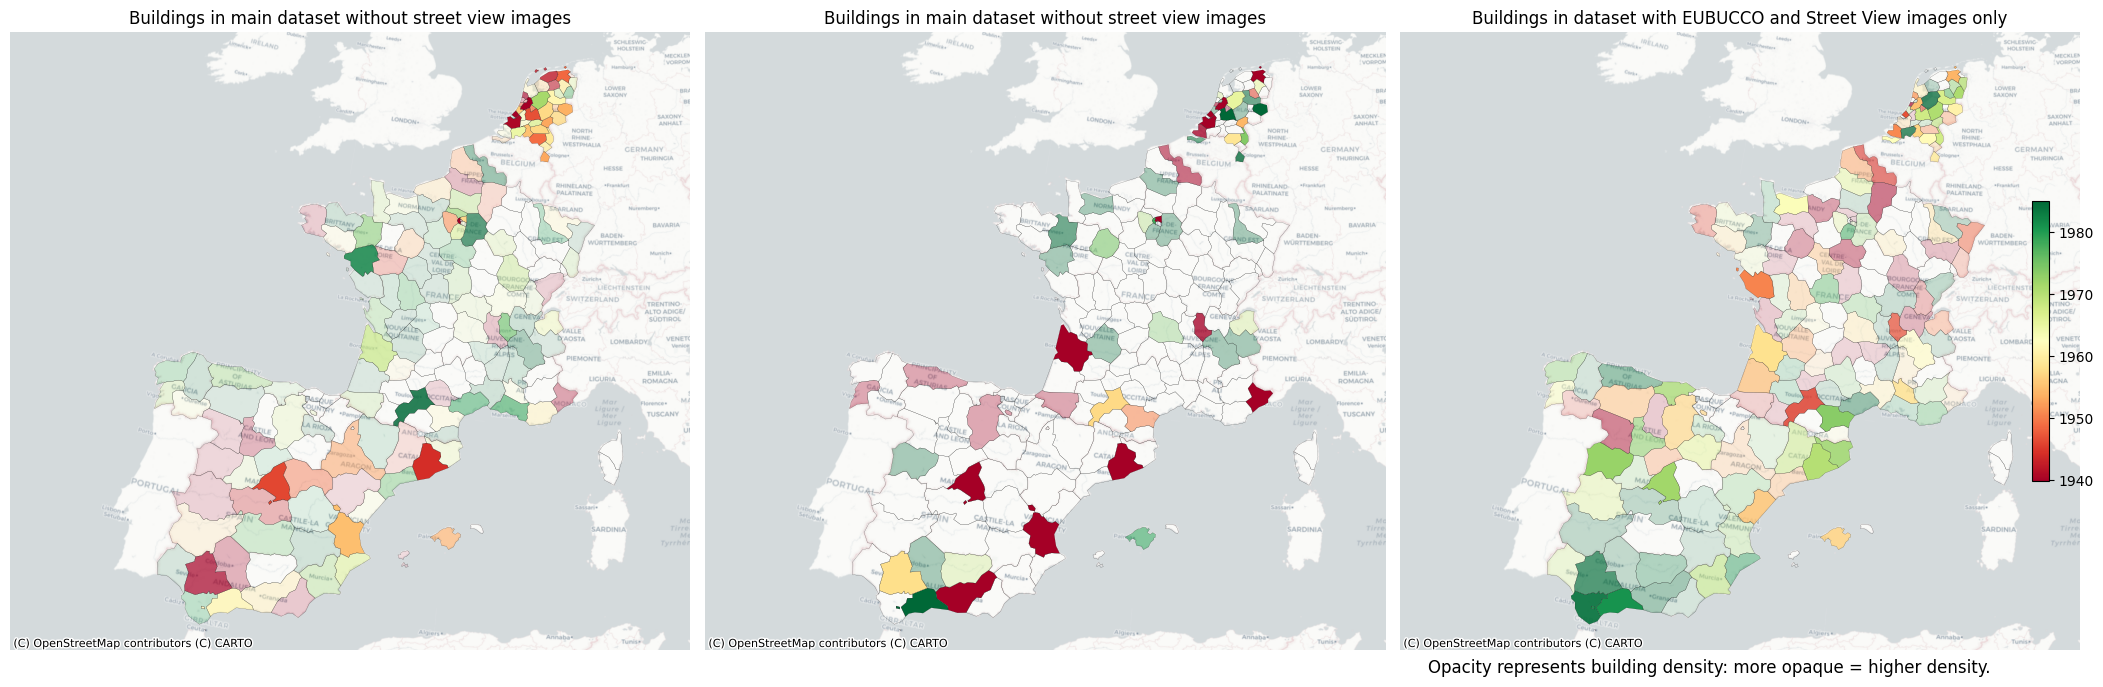

In [53]:
df_scaled = df_scaled.rename(columns={'age': 'age_right'})

# Convert geometry data from WKT format if necessary
df['geometry'] = df['geometry'].apply(wkt.loads)
df_scaled['geometry'] = df_scaled['geometry'].apply(wkt.loads)

# Load and prepare GeoDataFrames
gdf = gpd.GeoDataFrame(df, geometry='geometry').set_crs(epsg=32632)
gdf_n = gdf.to_crs(epsg=3035)
df_scaled = df_scaled.drop(columns=['geometry'])
# convert to geodataframe
gdf_scaled = create_geodataframe(df_scaled, 'lat', 'lon')
# Setting coordinate system (assuming WGS84)
gdf_scaled.set_crs(epsg=4326, inplace=True)
# Transform the CRS to UTM zone 32N (EPSG:32632) so that distances are in meters
gdf_scaled_n = gdf_scaled.to_crs(epsg=3035)

# Filter GeoDataFrame for specific merge conditions
gdf_left_only = gdf_n[gdf_n['_merge'] == 'left_only']
gdf_both = gdf_n[gdf_n['_merge'] == 'both']

# Load and prepare NUTS3 shapefiles
nuts3 = gpd.read_file('/workspace/workspace/ufo-prediction/metadata/NUTS_RG_20M_2021_3035.shp.zip')
nuts3 = nuts3[nuts3['CNTR_CODE'].isin(['FR', 'NL', 'ES']) & (nuts3['LEVL_CODE'] == 3)]


def plot_map(data, title, ax, add_legend=False):
    buildings_nuts3 = gpd.sjoin(data, nuts3, how="inner", op='intersects')
    region_stats = buildings_nuts3.groupby('NUTS_ID').agg({'age_right': 'mean', 'geometry': 'count'}).rename(columns={'geometry': 'count'})
    nuts3_merged = nuts3.merge(region_stats, on='NUTS_ID', how='left')
    nuts3_merged['age_right'].fillna(nuts3_merged['age_right'].mean(), inplace=True)
    nuts3_merged['count'].fillna(0, inplace=True)
    #nuts3_merged.loc[nuts3_merged['count'] == 0, 'age_right'] = 1991
    
    count_10th = nuts3_merged['count'].quantile(0.1)
    count_90th = nuts3_merged['count'].quantile(0.9)
    opacity_normalized = np.interp(nuts3_merged['count'], [count_10th, count_90th], [0.1, 1])
    # Set opacity to zero where count is zero
    opacity_normalized[nuts3_merged['count'] == 0] = 0
    
    color_min = nuts3_merged['age_right'].quantile(0.1)
    color_max = nuts3_merged['age_right'].quantile(0.9)
    
    nuts3_merged.boundary.plot(ax=ax, linewidth=0.1, color="black")
    plot = nuts3_merged.plot(ax=ax, column='age_right', cmap='RdYlGn',
                             alpha=opacity_normalized, vmin=color_min, vmax=color_max)

    ctx.add_basemap(ax, crs=nuts3_merged.crs.to_string(), source=ctx.providers.CartoDB.Positron, zoom=6)
    ax.set_xlim([2300000, 4500000])
    ax.set_ylim([1500000, 3500000])
    ax.set_title(title)
    ax.set_axis_off()

    if add_legend:
        # Create colorbar as a legend
        sm = ScalarMappable(norm=Normalize(vmin=color_min, vmax=color_max), cmap='RdYlGn')
        sm._A = []
        cbar_ax = fig.add_axes([0.97, 0.3, 0.008, 0.4])  # Adjust these values to position the color bar
        fig.colorbar(sm, cax=cbar_ax)
        cbar_ax.set_label('Average Age of Buildings')

# Create figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(21, 7))

# Plot each map
plot_map(gdf_left_only, 'Buildings in main dataset without street view images', axs[0])
plot_map(gdf_both, 'Buildings in main dataset without street view images', axs[1])
plot_map(gdf_scaled_n, 'Buildings in dataset with EUBUCCO and Street View images only', axs[2], add_legend=True)

# Add a custom annotation for opacity explanation in the right corner of the figure
fig.text(0.95, 0.02, 'Opacity represents building density: more opaque = higher density.', ha='right', va='bottom', fontsize=12)
fig.subplots_adjust(right=0.9)  

plt.tight_layout()
plt.show()

# Correlation between age measures

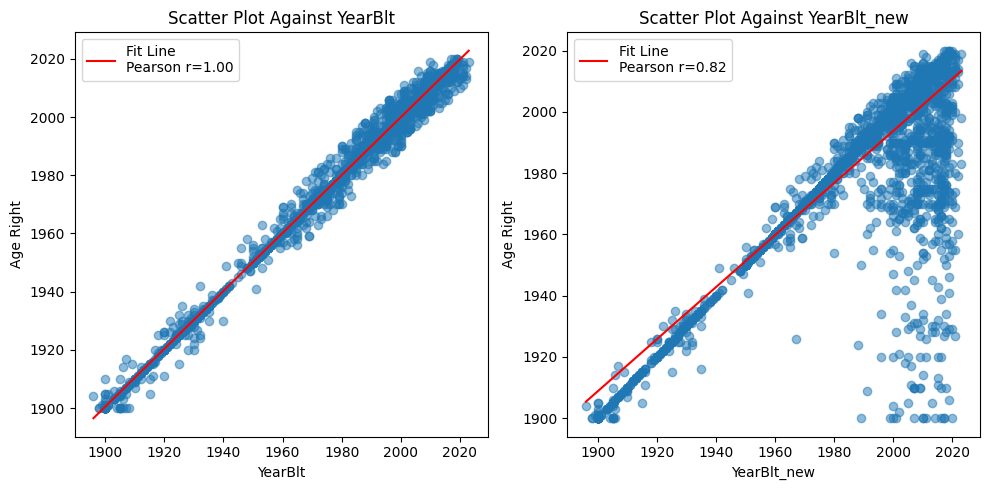

In [56]:
# Load your DataFrame here, example:
# df = pd.read_csv('path_to_your_data.csv')

# Prepare the figure and axes
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# List of year columns
year_columns = ['YearBlt', 'YearBlt_new']
titles = ['Against YearBlt', 'Against YearBlt_new']

for ax, col, title in zip(axs, year_columns, titles):
    # Drop NaN values for the pair to avoid errors in calculations
    subset = df[['age_right', col]].dropna()
    x = subset[col].values.reshape(-1, 1)  # Reshape for sklearn
    y = subset['age_right'].values

    # Calculate Pearson Correlation Coefficient
    corr_coef, _ = pearsonr(x.flatten(), y)

    # Fit linear regression
    model = LinearRegression().fit(x, y)
    line_x = np.linspace(x.min(), x.max(), 100)
    line_y = model.predict(line_x.reshape(-1, 1))

    # Plotting
    ax.scatter(x, y, alpha=0.5)
    ax.plot(line_x, line_y, 'r-', label=f'Fit Line\nPearson r={corr_coef:.2f}')
    ax.set_title(f'Scatter Plot {title}')
    ax.set_xlabel(col)
    ax.set_ylabel('Age Right')
    ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
path_data_RCA = os.path.join(dataset.DATA_DIR, 'rca-ufo-merge_ALL_descStata.csv')
matches = pd.read_csv(path_data_RCA, encoding='latin1')

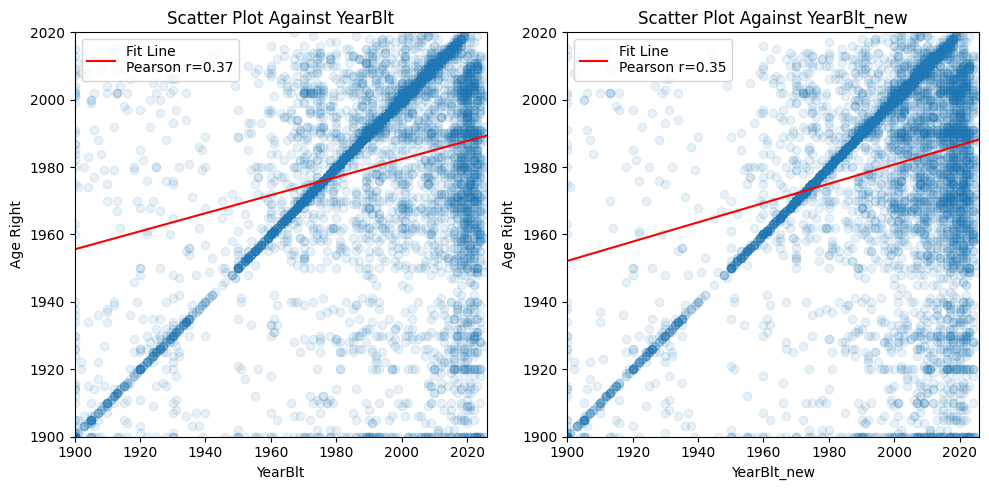

In [93]:
# Exclusions and filtering
exclusions = ['footprint filter', 'no match']
df2 = matches[~matches['match_type'].isin(exclusions)]
df2 = df2[df2['age_right'] >= 1900]

# Prepare the figure and axes
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# List of year columns
year_columns = ['YearBlt', 'YearBlt_new']
titles = ['Against YearBlt', 'Against YearBlt_new']

for ax, col, title in zip(axs, year_columns, titles):
    # Drop NaN values for the pair to avoid errors in calculations
    subset = df2[['age_right', col]].dropna()
    x = subset[col].values.reshape(-1, 1)  # Reshape for sklearn
    y = subset['age_right'].values

    # Calculate Pearson Correlation Coefficient
    corr_coef, _ = pearsonr(x.flatten(), y)

    # Fit linear regression
    model = LinearRegression().fit(x, y)
    line_x = np.linspace(1900, x.max(), 100)  # Start line_x at 1900
    line_y = model.predict(line_x.reshape(-1, 1))

    # Plotting with adjusted alpha for better visibility of density
    ax.scatter(x, y, alpha=0.1)  # Set alpha to a lower value for transparency
    ax.plot(line_x, line_y, 'r-', label=f'Fit Line\nPearson r={corr_coef:.2f}')
    ax.set_title(f'Scatter Plot {title}')
    ax.set_xlabel(col)
    ax.set_ylabel('Age Right')
    ax.set_xlim([1900, max(x.max(), 2020)])  # Ensure x-axis starts at 1900 and adjust the max accordingly
    ax.set_ylim([1900, max(y.max(), 2020)])  # Ensure y-axis also starts at 1900
    ax.legend()

plt.tight_layout()
plt.show()

# Merging data sources

In [64]:
print(len(matches))

24546


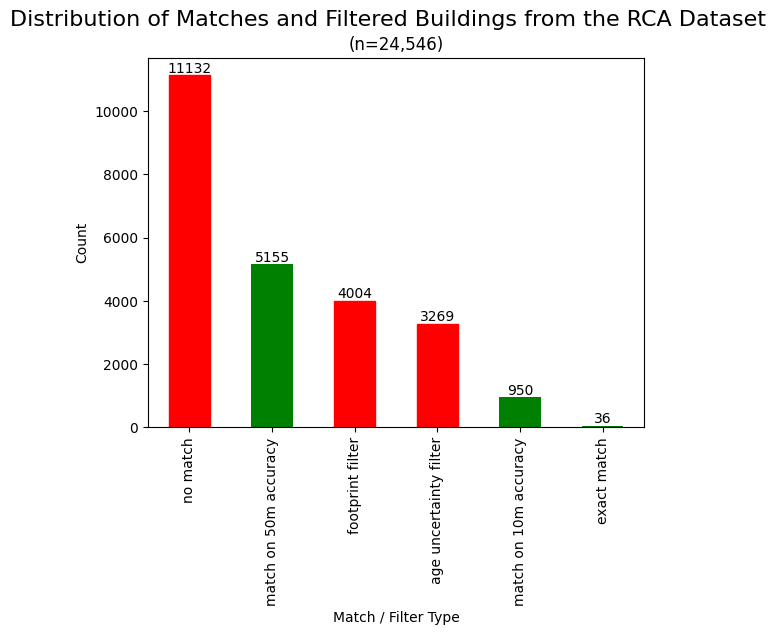

In [84]:
matches['match_type'] = matches['match_type'].replace('age uncertainty', 'age uncertainty filter')

# Sample DataFrame creation for demonstration
data = {'match_type': ['match', 'no match', 'footprint filter', 'age uncertainty filter', 'match', 'match']}

# Create the plot
ax = matches['match_type'].value_counts().plot(kind='bar', color='green')  # Default color set to green

# Retrieve the labels from the x-axis, which are the match_types
labels = [item.get_text() for item in ax.get_xticklabels()]

# Recolor specific bars
for bar, label in zip(ax.patches, labels):
    if label in ['no match', 'footprint filter', 'age uncertainty filter']:
        bar.set_color('red')  # Set the color to red for specific match types

plt.xlabel('Match / Filter Type')
plt.ylabel('Count')
plt.suptitle('Distribution of Matches and Filtered Buildings from the RCA Dataset', fontsize=16)
plt.title('(n=24,546)') 


# Adding the text on top of each bar
for bar in ax.patches:
    # The text to display (bar height)
    yval = bar.get_height()
    # Placing the text above the bar
    ax.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), va='bottom', ha='center')

plt.show()


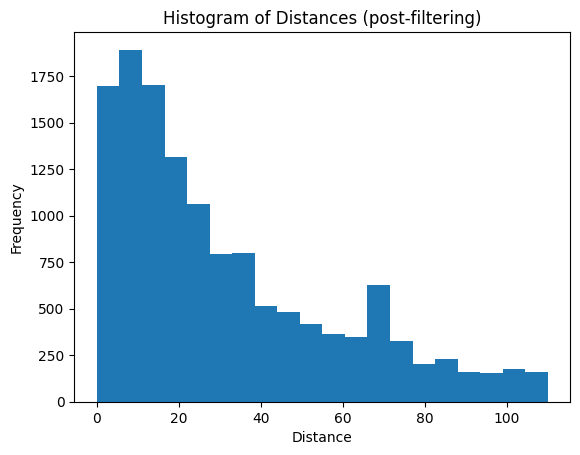

In [86]:
exclusions = ['footprint filter', 'age uncertainty filter', 'no match']

# Filter the DataFrame to exclude rows with the specified match types
filtered_matches = matches[~matches['match_type'].isin(exclusions)]

# Assuming 'matches' is your DataFrame and it has a numerical column named 'distances'
matches['distances'].plot(kind='hist', bins=20)  # You can adjust the number of bins

plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Distances (post-filtering)')
plt.show()

ESP <br>
Total buildings in ESP in RCA: 3934 <br>
Total buildings in ESP in RCA with age:  <br>
Total matches: 2906 <br>
Matches after filtering those that have distance > footprint length: 1747 <br>
Matches after filtering for age differences > 10 years: 1482 <br>
Of which YearBlt is defined: 549 <br>

FRA <br>
Total buildings in FRA in RCA: 10476 <br>
Total buildings in FRA in RCA with age: 6393 <br>
Total matches: 3217, there is a lot of matches where the RCA year is near 2020, but the ufo one is much older. Youngest ufo building is 2017 which is also strange <br>
Matches after filtering those that have distance > footprint length: 1100 <br>
Matches after filtering for age differences > 10 years:  870 <br>
Of which YearBlt is defined: 408 <br>



NLD <br>
Total buildings in NLD in RCA: 10136 <br>
Total buildings in NLD in RCA with age: 8050 <br>
Total matches: 7318, there is a lot of matches where the RCA year is near 2020, but the ufo one is much older. Youngest ufo building is 2020 which is also strange <br>
Matches after filtering those that have distance > footprint length: 4560 <br>
Matches after filtering for age differences > 10 years: 3789 <br>
Of which YearBlt is defined: 3211 <br>

In [57]:
path_data_RCA = os.path.join(dataset.DATA_DIR, 'rca-ufo-CNN.csv')
df_svi = pd.read_csv(path_data_RCA, encoding='latin1')

In [61]:
df_svi2 = df_svi.loc[df_svi['_merge'] == 'both']
merge_counts = df_svi2['country'].value_counts()
print(merge_counts)
print(len(df_svi2))

country
Netherlands    229
Spain          202
France          66
Name: count, dtype: int64
497
